In [25]:
# Import common GIS tools
import numpy as np
import xarray as xr                # Used for multi-dimensional arrays (eg,time,lat,long)
import matplotlib.pyplot as plt
import rioxarray as rio            # allows to read,write and process geospatial data
import rasterio                    # reads & write raster geospatial data format 
from rasterio.transform import from_origin
import rioxarray as rxr

from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac                  # loads geospatial data as xarray objects
import pystac_client              # used for finding specific geospatial data
import planetary_computer         # find geosaptial data from microsoft planetary website
from odc.stac import stac_load    # load geospatial data into data structure suitable for analysis

In [26]:
import pandas as pd
from tqdm import tqdm
from pyproj import Proj, Transformer, CRS
import seaborn as sb

In [27]:

try:
    del uhi_data , df , ground_df , indices
    print("successfully deleted")
except:
    print("it has already been deleted")

it has already been deleted


### 1) Load the test data


In [29]:
ground_df = pd.read_csv("Training_data_uhi_index_2025-02-18.csv")
ground_df

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245


### 2) Open the file
we will gather the data collected from sentinel and landsat and store in a dataframe.


#### Sentinel 2 Data

In [31]:
filename = "S2_sample1.tiff"


In [32]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
# The line data = rio.open_rasterio(tiff_path) loads a GeoTIFF file as an xarray DataArray, 
# which includes raster bands, pixel values, and spatial metadata. 
    
# The line tiff_crs = data.rio.crs retrieves the Coordinate Reference System (CRS) of the raster, 
# which is needed for geospatial transformations and aligning coordinates correctly.
    data = rio.open_rasterio(tiff_path) 
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    # These lines extract the Latitude and Longitude columns from the DataFrame (df) and convert them into NumPy arrays. 
    # This allows efficient numerical operations and iteration when mapping coordinates to the GeoTIFF raster.

    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # defines the  EPSG:4326 system
    proj_tiff = Proj(tiff_crs) # defines the crs system used in geotifff image 
    
    # Create a transformer object to convert from latitude and longitude coordinates (EPSG:4326) into the coordinate reference system (CRS)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)


# Iterate over the latitudes and longitudes, and extract the all band values
# Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    band_values = {f'B{band}': [] for band in range(1, data.sizes['band'] + 1)}

    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        for band in range(1, data.sizes['band'] + 1):
            value = data.sel(x=lon, y=lat, band=band, method="nearest").values
            band_values[f'B{band}'].append(value)  # Now correctly initialized

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame(band_values)
    return df

In [33]:
df = map_satellite_data(filename, "Training_data_uhi_index_2025-02-18.csv")

C:\Users\steph\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Mapping values: 100%|███████████████████████████████████████████████████████████| 11229/11229 [01:23<00:00, 134.90it/s]


In [34]:
indices = pd.DataFrame()

In [35]:
df

,B1,B2,B3,B4,B5,B6,B7,B8,B9
0,372.0,118.0,213.0,350.0,378.0,440.0,452.0,464.0,847.0
1,372.0,118.0,213.0,350.0,378.0,440.0,452.0,464.0,847.0
2,372.0,157.0,255.0,424.0,454.0,632.0,473.0,547.0,947.0
3,372.0,157.0,255.0,424.0,454.0,632.0,473.0,547.0,947.0
4,142.0,503.0,643.0,862.0,878.0,913.0,1038.0,1355.0,1209.0
...,...,...,...,...,...,...,...,...,...
11224,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0
11225,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0
11226,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0
11227,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0


In [36]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
indices['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'])
indices['NDVI'] = indices['NDVI'].replace([np.inf, -np.inf], np.nan) 

C:\Users\steph\AppData\Local\Temp\ipykernel_51372\825904554.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  indices['NDVI'] = indices['NDVI'].replace([np.inf, -np.inf], np.nan)


In [37]:
L = 0.5  # Soil adjustment factor for SAVI

# Calculate different indices
indices['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4']) # Measure Vegetation Health
indices['NDVI'] = indices['NDVI'].replace([np.inf, -np.inf], np.nan) 


indices['NDWI'] = (df['B3'] - df['B8']) / (df['B3'] + df['B8']) # Detects water bodies.
indices['NDWI'] = indices['NDWI'].replace([np.inf, -np.inf], np.nan) 


# B11 was saved as B9 in this notebook
indices['NDBI'] = (df['B9'] - df['B8']) / (df['B9'] + df['B8']) # Identifies built-up/urban areas.
indices['NDBI'] = indices['NDBI'].replace([np.inf, -np.inf], np.nan)

indices['SAVI'] = ((df['B8'] - df['B4']) * (1 + L)) / (df['B8'] + df['B4'] + L)
indices['SAVI'] = indices['SAVI'].replace([np.inf, -np.inf], np.nan)


indices['EVI'] = 2.5 * (df['B8'] - df['B4']) / (df['B8'] + 6 * df['B4'] - 7.5 * df['B2'] + 1)
indices['EVI'] = indices['EVI'].replace([np.inf, -np.inf], np.nan)

# B11 was saved as B9 in this notebook

indices['MNDWI'] = (df['B3'] - df['B9']) / (df['B3'] + df['B9']) # enhanced water body detection
indices['MNDWI'] = indices['MNDWI'].replace([np.inf, -np.inf], np.nan)


indices['GNDVI'] = (df['B8'] - df['B3']) / (df['B8'] + df['B3']) # enhance vegetation health
indices['GNDVI'] = indices['GNDVI'].replace([np.inf, -np.inf], np.nan)


C:\Users\steph\AppData\Local\Temp\ipykernel_51372\3496523263.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  indices['NDVI'] = indices['NDVI'].replace([np.inf, -np.inf], np.nan)
C:\Users\steph\AppData\Local\Temp\ipykernel_51372\3496523263.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  indices['NDWI'] = indices['NDWI'].replace([np.inf, -np.inf], np.nan)
C:\Users\steph\AppData\Local\Temp\ipykernel_51372\3496523263.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

In [38]:
indices

,NDVI,NDWI,NDBI,SAVI,EVI,MNDWI,GNDVI
0,0.140049,-0.370753,0.292143,0.209945,0.169643,-0.598113,0.370753
1,0.140049,-0.370753,0.292143,0.209945,0.169643,-0.598113,0.370753
2,0.126674,-0.364090,0.267738,0.189913,0.160616,-0.575707,0.364090
3,0.126674,-0.364090,0.267738,0.189913,0.160616,-0.575707,0.364090
4,0.222373,-0.356356,-0.056942,0.333484,0.447287,-0.305616,0.356356
...,...,...,...,...,...,...,...
11224,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985
11225,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985
11226,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985
11227,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985


In [39]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2,dataset3):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2,dataset3], axis=1)
    return data

In [40]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(df,indices,ground_df)
uhi_data

,B1,B2,B3,B4,B5,B6,B7,B8,B9,NDVI,NDWI,NDBI,SAVI,EVI,MNDWI,GNDVI,Longitude,Latitude,datetime,UHI Index
0,372.0,118.0,213.0,350.0,378.0,440.0,452.0,464.0,847.0,0.140049,-0.370753,0.292143,0.209945,0.169643,-0.598113,0.370753,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,372.0,118.0,213.0,350.0,378.0,440.0,452.0,464.0,847.0,0.140049,-0.370753,0.292143,0.209945,0.169643,-0.598113,0.370753,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,372.0,157.0,255.0,424.0,454.0,632.0,473.0,547.0,947.0,0.126674,-0.364090,0.267738,0.189913,0.160616,-0.575707,0.364090,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,372.0,157.0,255.0,424.0,454.0,632.0,473.0,547.0,947.0,0.126674,-0.364090,0.267738,0.189913,0.160616,-0.575707,0.364090,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,142.0,503.0,643.0,862.0,878.0,913.0,1038.0,1355.0,1209.0,0.222373,-0.356356,-0.056942,0.333484,0.447287,-0.305616,0.356356,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985,-73.957112,40.790253,24-07-2021 15:59,0.981245


In [41]:
uhi_data=uhi_data.reset_index(drop=True)

In [42]:

uhi_data = uhi_data.replace([np.inf, -np.inf], np.nan).dropna()


In [43]:
uhi_data

,B1,B2,B3,B4,B5,B6,B7,B8,B9,NDVI,NDWI,NDBI,SAVI,EVI,MNDWI,GNDVI,Longitude,Latitude,datetime,UHI Index
0,372.0,118.0,213.0,350.0,378.0,440.0,452.0,464.0,847.0,0.140049,-0.370753,0.292143,0.209945,0.169643,-0.598113,0.370753,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,372.0,118.0,213.0,350.0,378.0,440.0,452.0,464.0,847.0,0.140049,-0.370753,0.292143,0.209945,0.169643,-0.598113,0.370753,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,372.0,157.0,255.0,424.0,454.0,632.0,473.0,547.0,947.0,0.126674,-0.364090,0.267738,0.189913,0.160616,-0.575707,0.364090,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,372.0,157.0,255.0,424.0,454.0,632.0,473.0,547.0,947.0,0.126674,-0.364090,0.267738,0.189913,0.160616,-0.575707,0.364090,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,142.0,503.0,643.0,862.0,878.0,913.0,1038.0,1355.0,1209.0,0.222373,-0.356356,-0.056942,0.333484,0.447287,-0.305616,0.356356,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,2.0,347.0,593.0,798.0,1112.0,1598.0,1836.0,2224.0,2063.0,0.471873,-0.578985,-0.037555,0.707692,0.808298,-0.553464,0.578985,-73.957112,40.790253,24-07-2021 15:59,0.981245


<Axes: >

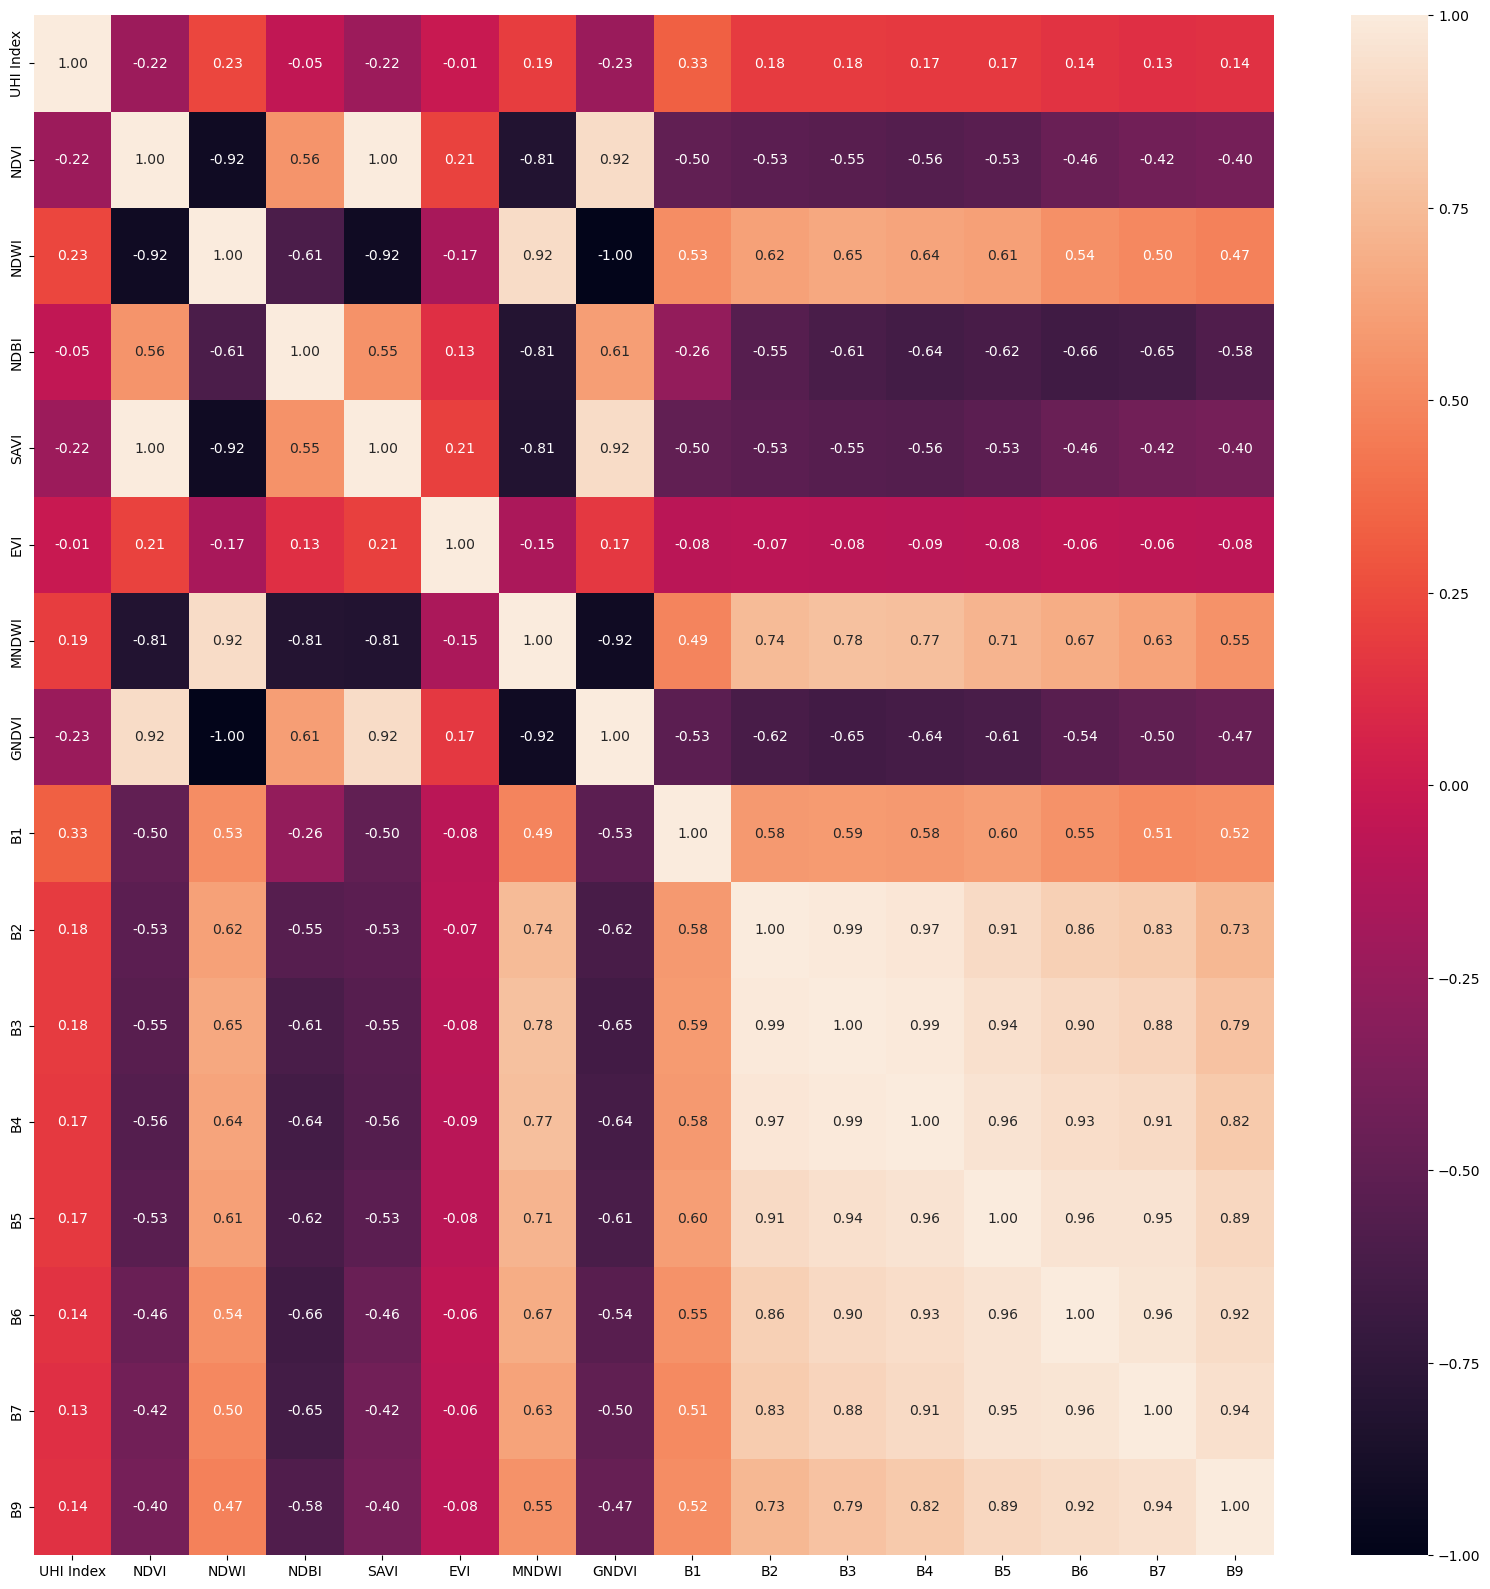

In [44]:
plt.figure(figsize=(20, 20))  # Adjust the width and height as needed


sb.heatmap(uhi_data[['UHI Index', 'NDVI', 'NDWI',
       'NDBI', 'SAVI', 'EVI','MNDWI','GNDVI','B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',  'B9']].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

#### Lansat DATA collection

In [46]:
filename_lst = "Landsat_LST.tiff"
filename_bands = "Landsat_bands1.tiff"

In [47]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_landslat(spectral_band, csv_path ):
    
# The line data = rio.open_rasterio(tiff_path) loads a GeoTIFF file as an xarray DataArray, 
# which includes raster bands, pixel values, and spatial metadata. 
    
# The line tiff_crs = data.rio.crs retrieves the Coordinate Reference System (CRS) of the raster, 
# which is needed for geospatial transformations and aligning coordinates correctly.
    data = rio.open_rasterio(spectral_band) 
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    # These lines extract the Latitude and Longitude columns from the DataFrame (df) and convert them into NumPy arrays. 
    # This allows efficient numerical operations and iteration when mapping coordinates to the GeoTIFF raster.

    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # defines the  EPSG:4326 system
    proj_tiff = Proj(tiff_crs) # defines the crs system used in geotifff image 
    
    # Create a transformer object to convert from latitude and longitude coordinates (EPSG:4326) into the coordinate reference system (CRS)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

 
    
    coastal = []
    blue = []
    green = []
    red = []
    nir08 = []
    swir16 = []
    swir22 = []
    pan = []
    cirrus = []
    lwir11 = []
    lwir12 = []

    # Iterate over latitudes and longitudes, extracting band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        coastal.append(data.sel(x=lon, y=lat, band=1, method="nearest").values)   # Coastal (Band 1)
        blue.append(data.sel(x=lon, y=lat, band=2, method="nearest").values)      # Blue (Band 2)
        green.append(data.sel(x=lon, y=lat, band=3, method="nearest").values)     # Green (Band 3)
        red.append(data.sel(x=lon, y=lat, band=4, method="nearest").values)       # Red (Band 4)
        nir08.append(data.sel(x=lon, y=lat, band=5, method="nearest").values)     # Near-Infrared (Band 5)
        swir16.append(data.sel(x=lon, y=lat, band=6, method="nearest").values)    # SWIR1 (Band 6)
        swir22.append(data.sel(x=lon, y=lat, band=7, method="nearest").values)    # SWIR2 (Band 7)
       
    
    # Create a DataFrame to store the band values
    df = pd.DataFrame({
        "coastal": coastal,
        "blue": blue,
        "green": green,
        "red": red,
        "nir08": nir08,
        "swir16": swir16,
        "swir22": swir22,
     
    })





    
    return df 

In [48]:
df_landslat  = map_satellite_data_landslat(filename_bands, "Training_data_uhi_index_2025-02-18.csv" )

C:\Users\steph\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Mapping values: 100%|███████████████████████████████████████████████████████████| 11229/11229 [01:01<00:00, 181.64it/s]


In [49]:
df_landslat

,coastal,blue,green,red,nir08,swir16,swir22
0,0.08215,0.09061999999999998,0.11168499999999998,0.1257375,0.16198250000000003,0.15725250000000002,0.1405325
1,0.08215,0.09061999999999998,0.11168499999999998,0.1257375,0.16198250000000003,0.15725250000000002,0.1405325
2,0.10052,0.115645,0.1344825,0.145785,0.17862,0.17268,0.13910250000000002
3,0.10052,0.115645,0.1344825,0.145785,0.17862,0.17268,0.13910250000000002
4,0.06488,0.07246999999999998,0.09534999999999999,0.097825,0.17853750000000002,0.14551000000000003,0.11031000000000002
...,...,...,...,...,...,...,...
11224,0.05992999999999998,0.0629825,0.08341500000000002,0.07940000000000003,0.31667000000000006,0.20144499999999999,0.11649749999999998
11225,0.05992999999999998,0.0629825,0.08341500000000002,0.07940000000000003,0.31667000000000006,0.20144499999999999,0.11649749999999998
11226,0.05992999999999998,0.0629825,0.08341500000000002,0.07940000000000003,0.31667000000000006,0.20144499999999999,0.11649749999999998
11227,0.05992999999999998,0.0629825,0.08341500000000002,0.07940000000000003,0.31667000000000006,0.20144499999999999,0.11649749999999998


In [50]:
uhi_data [['UHI Index']]

,UHI Index
0,1.030289
1,1.030289
2,1.023798
3,1.023798
4,1.021634
...,...
11224,0.972470
11225,0.972470
11226,0.981124
11227,0.981245


In [51]:
df_landslat["NDVI_landslat"] = (df_landslat['nir08'] - df_landslat['red'])/(df_landslat['nir08'] + df_landslat['red'])
df_landslat["NDVI_landslat"] = df_landslat["NDVI_landslat"].replace([np.inf, -np.inf], np.nan) 

C:\Users\steph\AppData\Local\Temp\ipykernel_51372\1714635395.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_landslat["NDVI_landslat"] = df_landslat["NDVI_landslat"].replace([np.inf, -np.inf], np.nan)


In [52]:
df_landslat["NDBI_landslat"] = (df_landslat["swir16"] - df_landslat["nir08"])/(df_landslat["swir16"] + df_landslat["nir08"])
df_landslat["NDBI_landslat"] = df_landslat["NDVI_landslat"].replace([np.inf, -np.inf], np.nan)

In [53]:
df_landslat["NDWI_landslat"] = (df_landslat["green"] - df_landslat["nir08"])/(df_landslat["green"] + df_landslat["nir08"])
df_landslat["NDWI_landslat"] = df_landslat["NDVI_landslat"].replace([np.inf, -np.inf], np.nan)

In [54]:
df_landslat["EVI_landslat"] = 2.5 * (df_landslat["nir08"] - df_landslat["red"]) / (df_landslat["nir08"] + 6 * df_landslat["red"] - 7.5 * df_landslat["blue"] + 1)
df_landslat["EVI_landslat"] = df_landslat["EVI_landslat"].replace([np.inf, -np.inf], np.nan)

C:\Users\steph\AppData\Local\Temp\ipykernel_51372\1074185862.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_landslat["EVI_landslat"] = df_landslat["EVI_landslat"].replace([np.inf, -np.inf], np.nan)


In [55]:
df_landslat["ARVI_landsat"] = (df_landslat["nir08"] - (2 * df_landslat["red"] - df_landslat["blue"])) / \
                     (df_landslat["nir08"] + (2 * df_landslat["red"] - df_landslat["blue"]))
df_landslat["ARVI_landsat"] = df_landslat["ARVI_landsat"].replace([np.inf, -np.inf], np.nan)

C:\Users\steph\AppData\Local\Temp\ipykernel_51372\2767170383.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_landslat["ARVI_landsat"] = df_landslat["ARVI_landsat"].replace([np.inf, -np.inf], np.nan)


In [56]:
df_landslat["NDMI"] = (df_landslat["nir08"] - df_landslat["swir16"]) / \
                      (df_landslat["nir08"] + df_landslat["swir16"])
df_landslat["NDMI"] = df_landslat["NDMI"].replace([np.inf, -np.inf], np.nan)

C:\Users\steph\AppData\Local\Temp\ipykernel_51372\2700942112.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_landslat["NDMI"] = df_landslat["NDMI"].replace([np.inf, -np.inf], np.nan)


In [57]:
df_landslat=df_landslat.reset_index(drop=True)
df_landslat = df_landslat.replace([np.inf, -np.inf], np.nan).dropna()

### 3) Train model 

In [59]:
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

#### - Creating model using Landsat 

In [104]:
# Split the data into features (X) and target (y), and then into training and testing sets

x_l =df_landslat[['NDWI_landslat',"NDBI_landslat" ,"NDVI_landslat"]]

y1 =   ground_df [['UHI Index']].values
X_train, X_test, y_train, y_test = train_test_split(x_l,y1, test_size=0.20,random_state=123)


In [62]:
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor



In [66]:
# Train the Random Forest model on the training data
model = ExtraTreesRegressor(n_estimators=200, random_state=42)
model.fit(X_train,y_train)

C:\Users\steph\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesRegressor(n_estimators=200, random_state=42)

In [67]:
# Generate predictions on the test set
y_pred_train = model.predict(X_train)

# Calculate metrics
r2_l1 = r2_score(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)

print("R² Score:", r2_l1)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R² Score: 0.9747877823784766
Mean Squared Error: 6.665389191750542e-06
Mean Absolute Error: 0.0017355480522764908


In [68]:

# Generate predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate metrics
r2_l = r2_score(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print("R² Score:", r2_l)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R² Score: 0.8667324036466918
Mean Squared Error: 3.4751443441007804e-05
Mean Absolute Error: 0.0032162606899582844


#### - Creating model using Sentinel 

In [70]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor



In [71]:
uhi_data.describe()

,NDVI,NDWI,NDBI,SAVI,EVI,MNDWI,GNDVI,Longitude,Latitude,UHI Index
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000
mean,0.199449,-0.323827,0.140692,0.298118,0.409429,-0.398627,0.323827,-73.933927,40.808800,1.000001
std,0.214314,0.262747,0.204181,0.318903,1.926722,0.298102,0.262747,0.028253,0.023171,0.016238
min,-0.133333,-0.997859,-0.417040,-0.198627,-16.666667,-0.997340,-0.129335,-73.994457,40.758792,0.956122
25%,0.059331,-0.459722,0.009664,0.088981,0.161492,-0.597959,0.130096,-73.955703,40.790905,0.988577
50%,0.124929,-0.236785,0.091876,0.187341,0.268426,-0.350604,0.236785,-73.932968,40.810688,1.000237
75%,0.264276,-0.130096,0.227003,0.396151,0.472272,-0.171239,0.459722,-73.909647,40.824515,1.011176
max,0.988889,0.129335,0.985915,1.479224,88.333333,0.518414,0.997859,-73.879458,40.859497,1.046036


In [72]:
x = uhi_data[['NDVI', 'NDWI',
       'NDBI']]  #predictors
y = uhi_data [['UHI Index']].values



In [73]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x,y, test_size=0.20,random_state=123)

#### - Using ExtraTreesRegressor

In [75]:
model_sentinel_ExtraTreesRegressor = ExtraTreesRegressor(n_estimators=200, random_state=42)
model_sentinel_ExtraTreesRegressor.fit(X_train2,y_train2)

C:\Users\steph\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesRegressor(n_estimators=200, random_state=42)

In [76]:
# Generate predictions on the test set
y_pred_train2 = model_sentinel_ExtraTreesRegressor.predict(X_train2)

# Calculate metrics
r2_s16 = r2_score(y_train2, y_pred_train2)
mse = mean_squared_error(y_train2, y_pred_train2)
mae = mean_absolute_error(y_train2, y_pred_train2)

print("R² Score:", r2_s16)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R² Score: 0.9747877823784766
Mean Squared Error: 6.6653891917505415e-06
Mean Absolute Error: 0.0017355480522764908


In [111]:
# Generate predictions on the test set
y_pred_test2 = model_sentinel_ExtraTreesRegressor.predict(X_test2)

# Calculate metrics
r2_l6 = r2_score(y_test2, y_pred_test2)
mse = mean_squared_error(y_test2, y_pred_test2)
mae = mean_absolute_error(y_test2, y_pred_test2)

print("R² Score:", r2_l6)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R² Score: 0.8920220363791267
Mean Squared Error: 2.8156807793681104e-05
Mean Absolute Error: 0.0030315045319627846


#### - Using Xgb model

In [79]:
# Train the Random Forest model on the training data
model_sentinel = XGBRegressor(n_estimators=200, random_state=42, enable_categorical=True)
X_train_SVR = X_train2.astype('float64')
X_test_SVR = X_test2.astype('float64')
y_train_SVR = y_train2.astype('float64')
y_test_SVR = y_test2.astype('float64')
model_sentinel.fit(X_train_SVR,y_train_SVR)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [80]:
# Generate predictions on the test set
y_pred_train2 = model_sentinel.predict(X_train_SVR)

# Calculate metrics
r2_s1 = r2_score(y_train_SVR, y_pred_train2)
mse = mean_squared_error(y_train_SVR, y_pred_train2)
mae = mean_absolute_error(y_train_SVR, y_pred_train2)

print("R² Score:", r2_s1)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R² Score: 0.9315887782765099
Mean Squared Error: 1.8085970251221753e-05
Mean Absolute Error: 0.0030593603447634293


In [81]:
# Generate predictions on the test set
y_pred_test2 = model_sentinel.predict(X_test_SVR)

# Calculate metrics 
r2_s = r2_score(y_test_SVR, y_pred_test2)
mse = mean_squared_error(y_test_SVR, y_pred_test2)
mae = mean_absolute_error(y_test_SVR, y_pred_test2)

print("R² Score:", r2_s)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R² Score: 0.8300577232705302
Mean Squared Error: 4.4314894089808994e-05
Mean Absolute Error: 0.004279572678757679


In [85]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor

#### - combining models using Stacking

Models trained separately on Landsat and Sentinel-2 data were combined using an Extra Trees Regressor in a stacked ensemble to improve prediction accuracy. While this approach significantly boosted performance on the validation set, the accuracy dropped notably when evaluated on the competition's unseen inference data. This suggests that the ensemble likely overfitted the training data, as initially anticipated.


In [90]:
from sklearn.ensemble import ExtraTreesRegressor


In [91]:
#y_pred_test = y_pred_test[:y_pred_test2.shape[0]]  # Trim to match y_pred_test2

X_meta = np.column_stack((y_pred_test, y_pred_test2))  # Ensure these are test predictions

# Fix y shape
#y_test = y_test[:y_pred_test2.shape[0]]
y_test = y_test.ravel()
# Train a meta-model (e.g., Linear Regression) on test data
meta_model = ExtraTreesRegressor(n_estimators=200, random_state=42)
meta_model.fit(X_meta, y_test)  # Use y_test, NOT y_train



ExtraTreesRegressor(n_estimators=200, random_state=42)

In [92]:
# Make final predictions using the stacked model
y_pred_test_final = meta_model.predict(X_meta)



In [93]:
# Calculate metrics
r2_final = r2_score(y_test, y_pred_test_final)  # Ensure y_test is used here
mse = mean_squared_error(y_test, y_pred_test_final)
mae = mean_absolute_error(y_test, y_pred_test_final)


In [94]:
print(r2_final)

0.9882990494395135


### 4) Predict UHI index 

In [96]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template.csv')


In [97]:
# Mapping satellite data for submission.
val_data_sentinel = map_satellite_data(filename , 'Submission_template.csv')

C:\Users\steph\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Mapping values: 100%|█████████████████████████████████████████████████████████████| 1040/1040 [00:07<00:00, 134.74it/s]


In [98]:
val_data_landsat = map_satellite_data_landslat (filename_bands, 'Submission_template.csv' )

C:\Users\steph\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Mapping values: 100%|█████████████████████████████████████████████████████████████| 1040/1040 [00:05<00:00, 176.17it/s]


In [99]:
val_data_landsat["NDVI_landslat"] = (val_data_landsat['nir08'] - val_data_landsat['red'])/(val_data_landsat['nir08'] + val_data_landsat['red'])
val_data_landsat["NDVI_landslat"] = val_data_landsat["NDVI_landslat"].replace([np.inf, -np.inf], np.nan)

val_data_landsat["NDWI_landslat"] = (val_data_landsat["green"] - val_data_landsat["nir08"])/(val_data_landsat["green"] + val_data_landsat["nir08"])
val_data_landsat["NDWI_landslat"] = val_data_landsat["NDWI_landslat"].replace([np.inf, -np.inf], np.nan)

val_data_landsat["EVI_landslat"] = 2.5 * (val_data_landsat["nir08"] - val_data_landsat["red"]) / (val_data_landsat["nir08"] + 6 * val_data_landsat["red"] - 7.5 * val_data_landsat["blue"] + 1)
val_data_landsat["EVI_landslat"] = val_data_landsat["EVI_landslat"].replace([np.inf, -np.inf], np.nan)



val_data_landsat["ARVI_landsat"] = (val_data_landsat["nir08"] - (2 * val_data_landsat["red"] - val_data_landsat["blue"])) / \
                     (val_data_landsat["nir08"] + (2 * val_data_landsat["red"] - val_data_landsat["blue"]))
val_data_landsat["ARVI_landsat"] = val_data_landsat["ARVI_landsat"].replace([np.inf, -np.inf], np.nan)

val_data_landsat["NDBI_landslat"] = (val_data_landsat["swir16"] - val_data_landsat["nir08"])/(val_data_landsat["swir16"] + val_data_landsat["nir08"])
val_data_landsat["NDBI_landslat"] = val_data_landsat["NDBI_landslat"].replace([np.inf, -np.inf], np.nan)


val_data_landsat["NDMI"] = (val_data_landsat["nir08"] - val_data_landsat["swir16"]) / \
                      (val_data_landsat["nir08"] + val_data_landsat["swir16"])
val_data_landsat["NDMI"] = val_data_landsat["NDMI"].replace([np.inf, -np.inf], np.nan)


C:\Users\steph\AppData\Local\Temp\ipykernel_51372\3774988671.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data_landsat["NDVI_landslat"] = val_data_landsat["NDVI_landslat"].replace([np.inf, -np.inf], np.nan)
C:\Users\steph\AppData\Local\Temp\ipykernel_51372\3774988671.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data_landsat["NDWI_landslat"] = val_data_landsat["NDWI_landslat"].replace([np.inf, -np.inf], np.nan)
C:\Users\steph\AppData\Local\Temp\ipykernel_51372\3774988671.py:8: FutureWarning: Downcasting behavi

In [ ]:
def UHI_model_predict(x_sentinel,x_landsat,y):
    y_pred_test_sentinel = model_sentinel.predict(x_sentinel)
    y_pred_test_landsat = model.predict(x_landsat)
    X_meta = np.column_stack((y_pred_test_sentinel, y_pred_test_landsat))
    # Make final predictions using the stacked model
    y_pred_test_final = meta_model.predict(X_meta)
    return y_pred_test_final

In [ ]:
y_pred_test_landsat = model_sentinel.predict(X_uhi_sentinel)


In [ ]:
Y_UHI_results_dataframe = pd.Series(y_pred_test_landsat)

In [ ]:
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':Y_UHI_results_dataframe.values})

In [ ]:
submission_df.to_csv("submission.csv",index = False)